In [1]:
!hostname

interactive2


In [1]:
%run ../ipython/ipy_setup.py
%matplotlib inline
import pysam
import math
from IPython import display
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

read_bpos = dict()

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    return outseq

def get_position_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outpos = None
    if in_pos in refmap:
        outpos = refmap[in_pos]
    return outpos

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C', 
                 'N':'N'}
    return ''.join([translate[s] for s in seq])

In [2]:
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')

sequences = dict( (s.name, s) for s in ht.FastaReader("/hpc/users/neffr01/jason_new/contig_000000F.fa") )

In [158]:
# get methylation by column (SLOW)
read_parsed_ipds_test = dict()
motif_ipd_values_test = dict()

pbar = ProgressBar(33500000)
motif_len = 11
mhl = int(math.floor(motif_len/2))
count = 0
for i in bam_fp.pileup():
    pbar.animate()
    count += 1
    if count > 1000:
        break
    ref_pos = i.reference_pos
    if ref_pos < mhl+1: continue # motif runs over start of ref
    ref_motif = str(sequences['000000F'][ref_pos-mhl:ref_pos+mhl+1]) # this is an 11-mer
    ref_3mer = ref_motif[mhl-1:mhl+2]
    for read in i.pileups:
        qpos = read.query_position
        if (qpos <= mhl)|(qpos >= read.alignment.query_length - mhl) :
            continue # cannot determine full motif
        read_3mer = get_matched_bases_in_read(read.alignment, range(ref_pos-1,ref_pos+2), read_bpos)
        if read_3mer != ref_3mer:
            continue
        # okay, if we've gotten this far it means we want to keep the ipd
        if read.alignment.qname not in read_parsed_ipds:
            read_parsed_ipds[read.alignment.qname] = [int(i) for i in read.alignment.get_tag('ip').strip('S').split(',')]
        ipd_val = read_parsed_ipds[read.alignment.qname][qpos]
        if ref_motif in motif_ipd_values:
            motif_ipd_values[ref_motif].append(ipd_val)
        else:
            motif_ipd_values[ref_motif] = [ipd_val]

In [ ]:
# get methylation by read (hopefully faster)
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')
motif_ipd_values_read = dict()

pbar = ProgressBar(450000)
count=0
for read in bam_fp.fetch():
    pbar.animate()
    ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
    rstart, rend = read.pos, read.aend
    rlen = rend-rstart
    refseq = str(sequences['000000F'][rstart:rend])
    refmap = get_refmap(read)
    for refpos in range(6,rlen-6):
        # translate the refpos value to a read-based coord
        basepos = get_position_in_read(read, refpos, refmap)
        if basepos == None: continue
        motif = refseq[refpos-5:refpos+6]
        ref_3mer = motif[4:7]
        read_3mer = get_matched_bases_in_read(read, range(refpos-1,refpos+2), refmap)
        if ref_3mer != read_3mer: continue
        ipd_value = ipd_values[basepos] 
        if motif in motif_ipd_values_read:
            motif_ipd_values_read[motif].append(ipd_value)
        else:
            motif_ipd_values_read[motif] = [ipd_value]
bam_fp.close()

import pickle
with open('/hpc/users/neffr01/2work/methyl_motif_priors/hg002_byread_3mers.pickle2', 'w') as fp:
    pickle.dump(motif_ipd_values_read, fp, 2)

[                  0%                  ]  179 of 450000 complete Elapsed: 1.4 minutes	 Remaining: 3574.7 minutes

In [128]:
import pickle
with open('/hpc/users/neffr01/2work/methyl_motif_priors/hg002_20k_columns.pickle2', 'w') as fp:
    pickle.dump(motif_ipd_values, fp, 2)

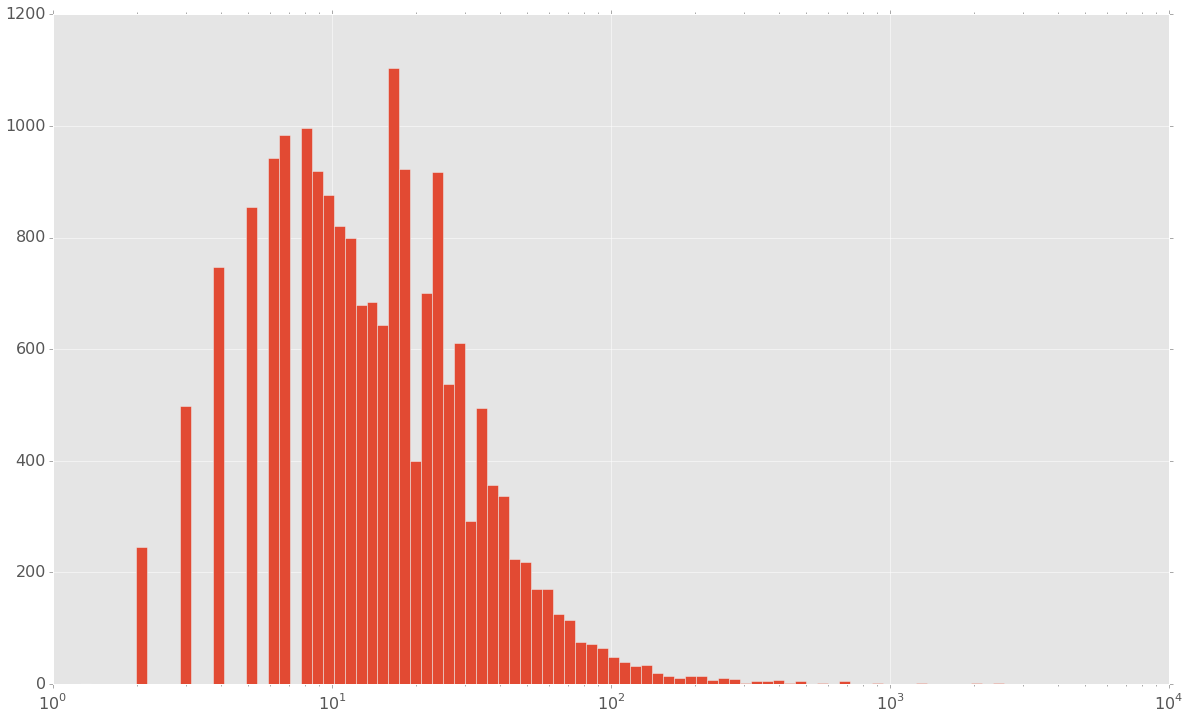

In [19]:
plt.hist(motif_ipd_values_read['CACCACTGCAC'], bins=np.logspace(0.1,4,100))
plt.xscale('log')
plt.show()

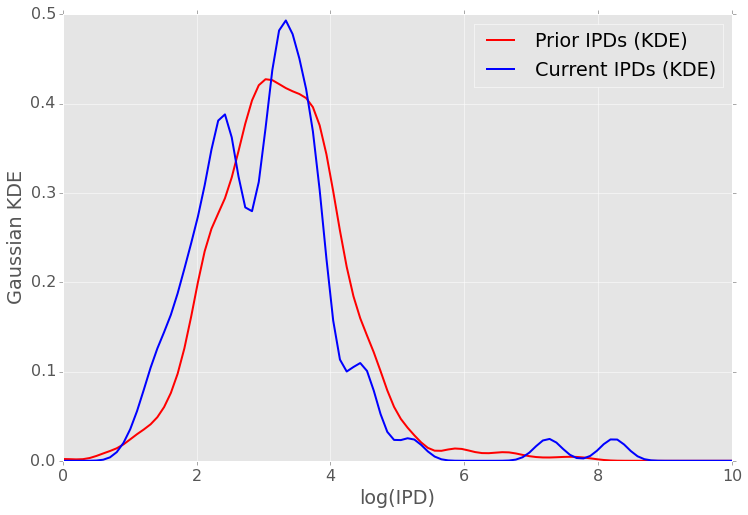

000000F 695 motif: ATCAGCCAGTT n_prior: 1000 n_curr: 81


KeyboardInterrupt: 

In [77]:
# get methylation by column (slow)
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')
motif_ipd_values = dict()

#pbar = ProgressBar(33500000)
count =0
for i in bam_fp.pileup():
    #pbar.animate()
    motif_arr = []
    ipds = []
    ref_pos = i.pos
    if i.pos < 6:
        continue # can't determine motif
    motif_arr.append(str(sequences['000000F'][ref_pos-5:ref_pos+6]))
    for read in i.pileups:
        qpos = read.query_position
        if (qpos < 6 )|(qpos > read.alignment.query_length - 6) :
            continue # cannot determine full motif
        read.alignment.get_reference_positions()
        ipds.append(int(read.alignment.get_tag('ip').split(',', qpos+1)[qpos].strip('S')))
    if max(ipds) < 1000:
        continue
    prior_ipds = [x for i in motif_arr for x in motif_ipd_values_read[i]]
    if len(prior_ipds) > 1000:
        prior_ipds = prior_ipds[0:1000]
    logx = np.linspace(0,10,100)
    kde_prior = kde_scipy(np.log(prior_ipds), logx)
    kde_curr = kde_scipy(np.log(ipds), logx)
    plt.plot(logx, kde_prior, 'r-', label="Prior IPDs (KDE)")
    plt.plot(logx, kde_curr, 'b-', label="Current IPDs (KDE)")
    #plt.hist(prior_ipds, bins=np.logspace(0.1,3,50),normed=True, color='b', alpha=0.5)
    #plt.hist(ipds, bins=np.logspace(0.1,3,50),normed=True, color='r', alpha=0.5)
    #plt.xscale('log')
    plt.legend()
    plt.xlabel("log(IPD)")
    plt.ylabel("Gaussian KDE")
    plt.show()
    print "000000F", ref_pos, "motif:", motif_arr[0], "n_prior:", len(prior_ipds), "n_curr:", len(ipds)
    sys.stdout.flush()
    wait = raw_input("PRESS ENTER TO CONTINUE.")
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [157]:
test_it(bam_fp)

TypeError: unhashable type: 'list'

In [161]:
import cProfile
import re
cProfile.run('test_it(bam_fp)', sort=2)

[                  0%                  ]  865 of 33500000 complete Elapsed: 0.2 minutes	 Remaining: 7803.9 minutes          1601498 function calls in 14.332 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   14.332   14.332 <string>:1(<module>)
        1    0.593    0.593   14.332   14.332 <ipython-input-158-151942e19214>:1(test_it)
      994    0.080    0.000   10.713    0.011 calignmentfile.pyx:3734(__get__)
    77539    0.108    0.000   10.634    0.000 calignmentfile.pyx:146(makePileupRead)
    77539   10.525    0.000   10.525    0.000 calignmentfile.pyx:127(makeAlignedSegment)
    74816    0.437    0.000    2.253    0.000 <ipython-input-159-69237dc8ab36>:30(get_matched_bases_in_read)
    74816    0.295    0.000    1.444    0.000 <ipython-input-159-69237dc8ab36>:49(get_seq)
    37171    0.036    0.000    1.149    0.000 calignmentfile.pyx:3602(__get__)
    37171    0.031    0.000    1.113    0